# Data Cleaning and EDA

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Loading the datasets

In [2]:
df = pd.read_excel('/content/premiums_rest.xlsx')
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
df.shape

(29904, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

👉 In short: it’s a best practice in EDA to clean up column names early, so your analysis runs smoothly without column-name-related issues.

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


# EDA and Data Cleaning


### Handling missing values

In [6]:
df.isna().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,9
employment_status,1
income_level,9
income_lakhs,0


Usually, when there are NaN values, we use techniques such as mean or median imputation to fill them in. However, in this case, we can simply drop the NaN values because the number of missing entries is small compared to the overall dataset.

In [7]:
df.dropna(inplace=True)
df.isna().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


### Handling Duplicate rows for future use

In [8]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


The min value of `number_of_dependants` column can not be a minus value

In [10]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

To fix this

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

,number_of_dependants
count,29886.000000
mean,2.385933
std,1.421137
min,0.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,5.000000


👉 In short: abs() removes the sign of a number and gives its magnitude.

### Visualizing Outliers

In [12]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

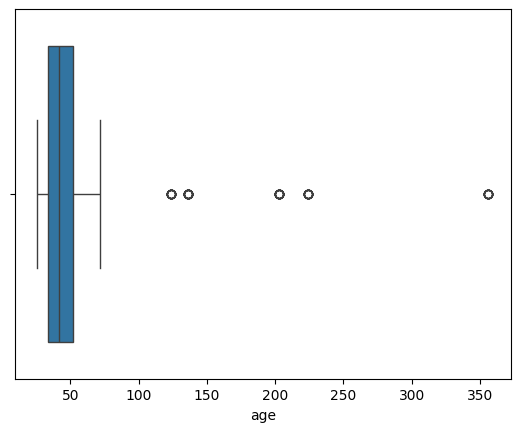

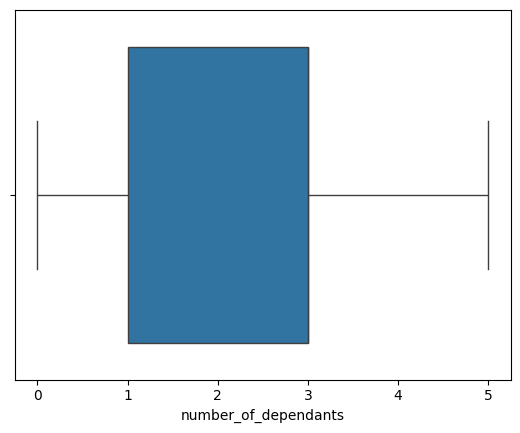

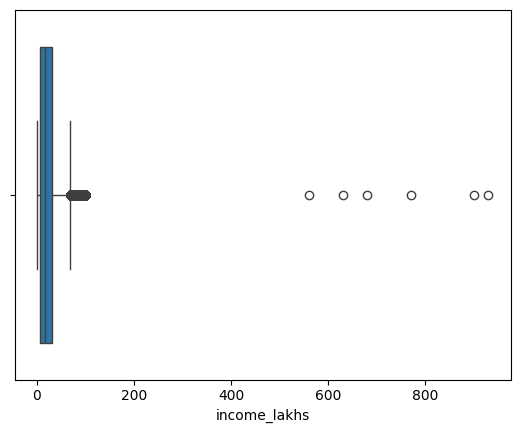

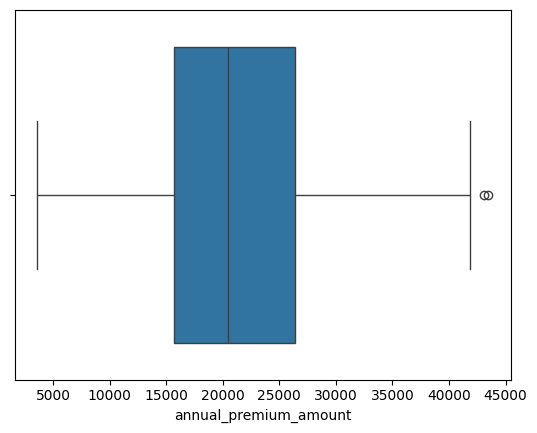

In [13]:
for col in numeric_columns:
  sns.boxplot(x=df[col])
  plt.show()

In [14]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [15]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


#### Outlier Treatment: Income Column

<Axes: xlabel='income_lakhs', ylabel='Count'>

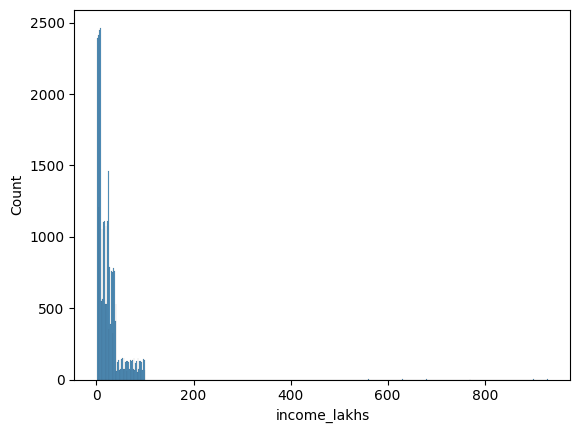

In [16]:
sns.histplot(df1.income_lakhs)

In [17]:
df1.income_lakhs.quantile([0.25, 0.75])

,income_lakhs
0.25,7.0
0.75,32.0


In [18]:
def get_iqr_bounds(col):
  Q1, Q3 = col.quantile([0.25, 0.75])
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  return lower_bound, upper_bound

In [19]:
lower, upper = get_iqr_bounds(df1.income_lakhs)
lower, upper

(-30.5, 69.5)

In [20]:
df1[df1.income_lakhs>upper].shape

(2090, 13)

In [21]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [22]:
df1[df1.income_lakhs>quantile_thresold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
1598,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4657,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
5399,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
6149,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
21176,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
24489,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [23]:
df1[df1.income_lakhs>quantile_thresold].shape

(6, 13)

In [24]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


### Univariate Analysis

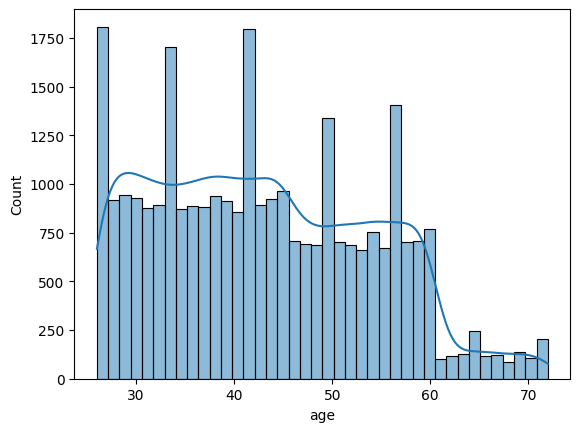

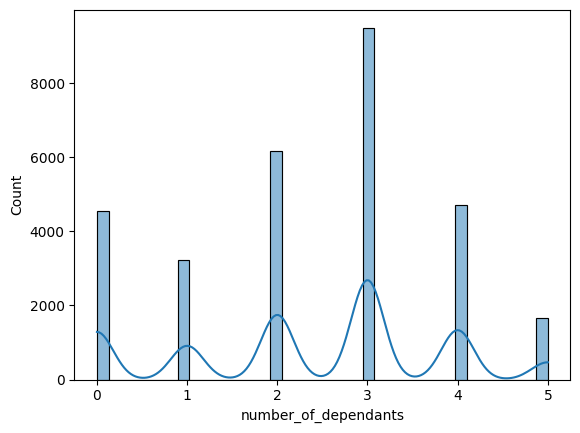

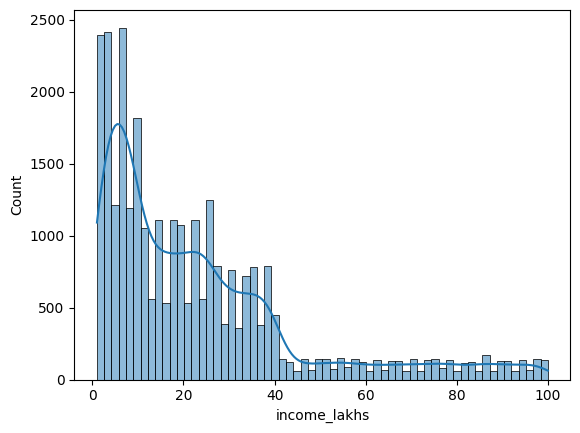

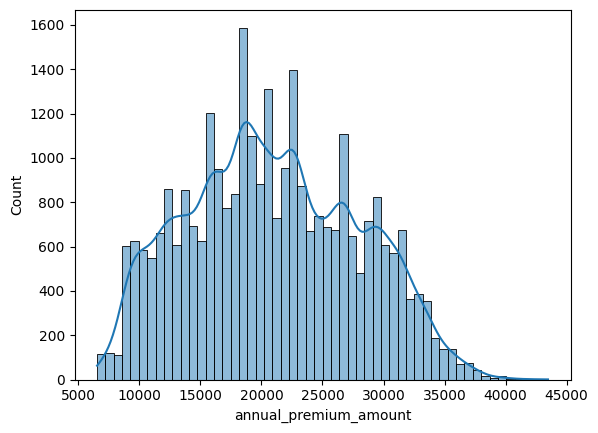

In [25]:
for col in numeric_columns:
  sns.histplot(df2[col], kde=True)
  plt.show()

Same thing but for a better visualization

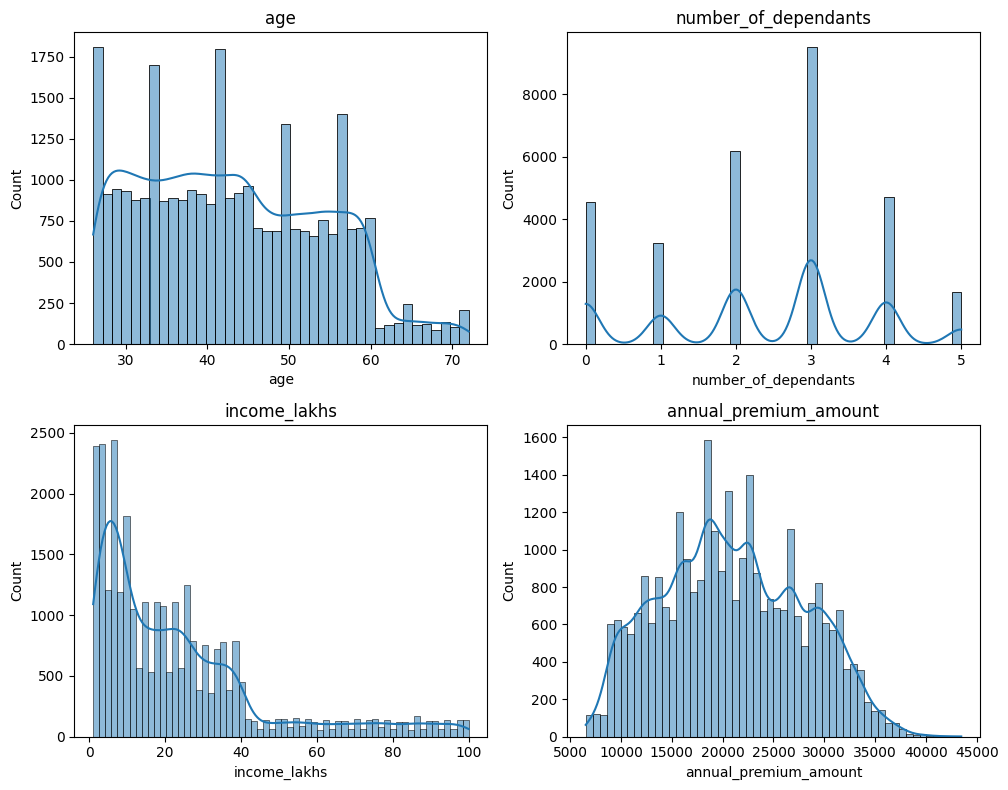

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) # You can adjust the size as necessary

for i, column in enumerate(numeric_columns):
  ax = axs[i//2, i%2] #Determines the position of the subplot in the grid
  sns.histplot(df2[column], kde=True, ax=ax)
  ax.set_title(column)

plt.tight_layout()
plt.show()

### Bivariate Analysis

<Axes: xlabel='age', ylabel='annual_premium_amount'>

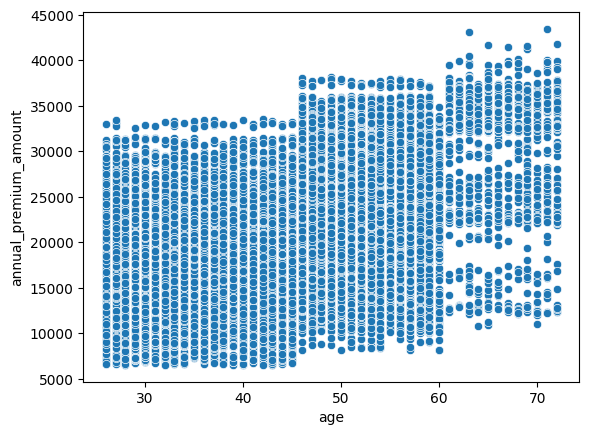

In [27]:
sns.scatterplot(df2, x='age', y='annual_premium_amount')

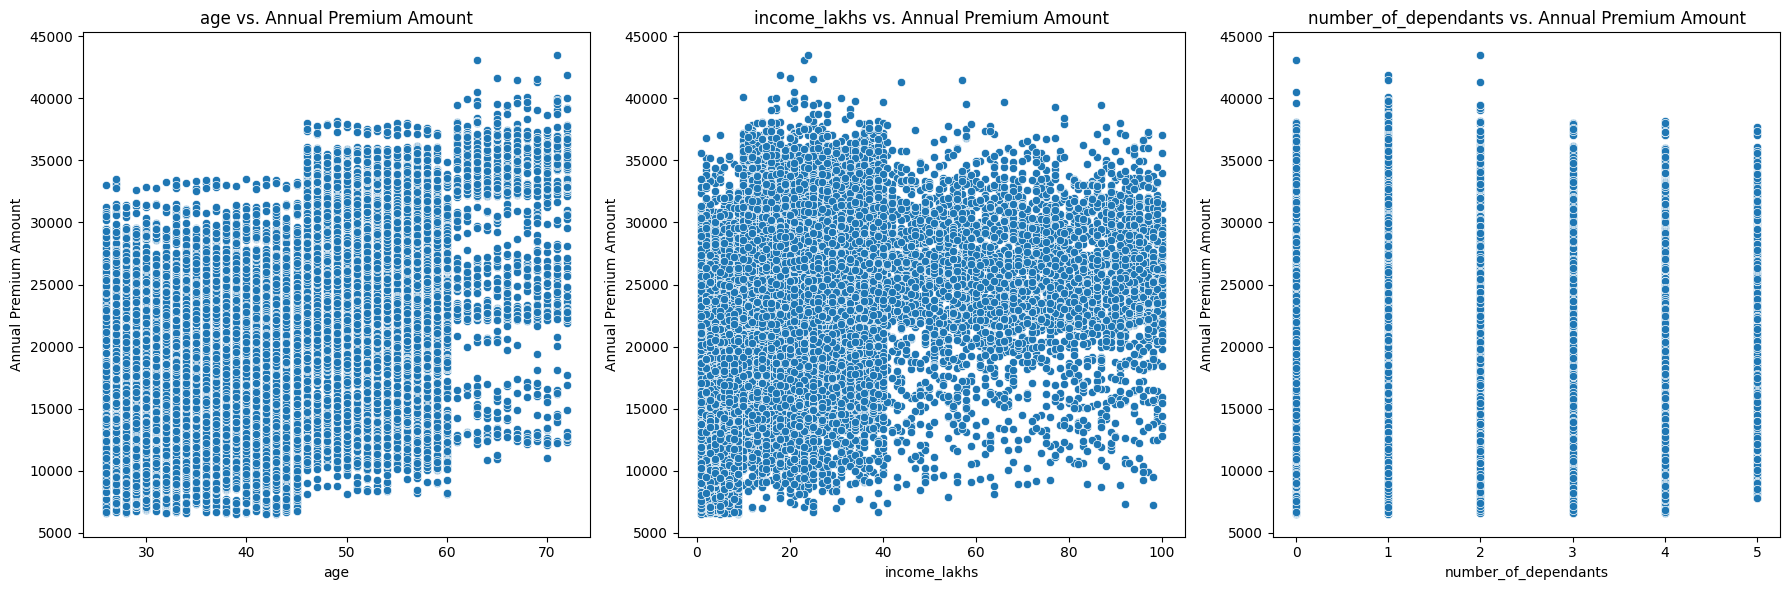

In [28]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6)) #You can adjust the size as necessary

for ax, column in zip(axes, numeric_features):
  sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
  ax.set_title(f'{column} vs. Annual Premium Amount')
  ax.set_xlabel(column)
  ax.set_ylabel('Annual Premium Amount')

plt.tight_layout() # You can adjust layout
plt.show()

### Analyizing Categorical Features

In [29]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
  print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [30]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking',
}, inplace=True)
df2['smoking_status'].unique()

/tmp/ipython-input-2412442927.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [31]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

,proportion
gender,
Male,0.549125
Female,0.450875


In [32]:
pct_count.index

Index(['Male', 'Female'], dtype='object', name='gender')

In [33]:
pct_count.values

array([0.54912481, 0.45087519])

<Axes: xlabel='gender'>

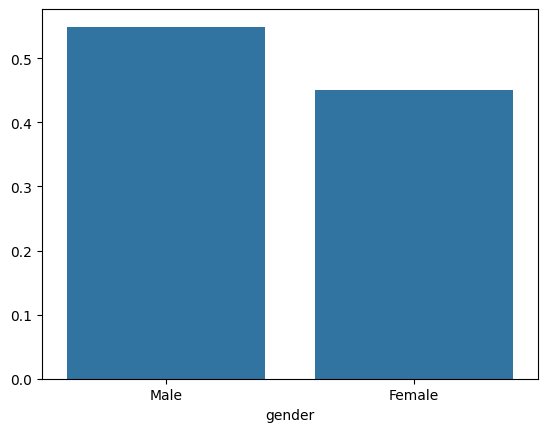

In [34]:
sns.barplot(x=pct_count.index, y=pct_count.values)

/tmp/ipython-input-530139555.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-530139555.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-530139555.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-530139555.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-530139555.py:15: UserWarning: set_ticklabels() should

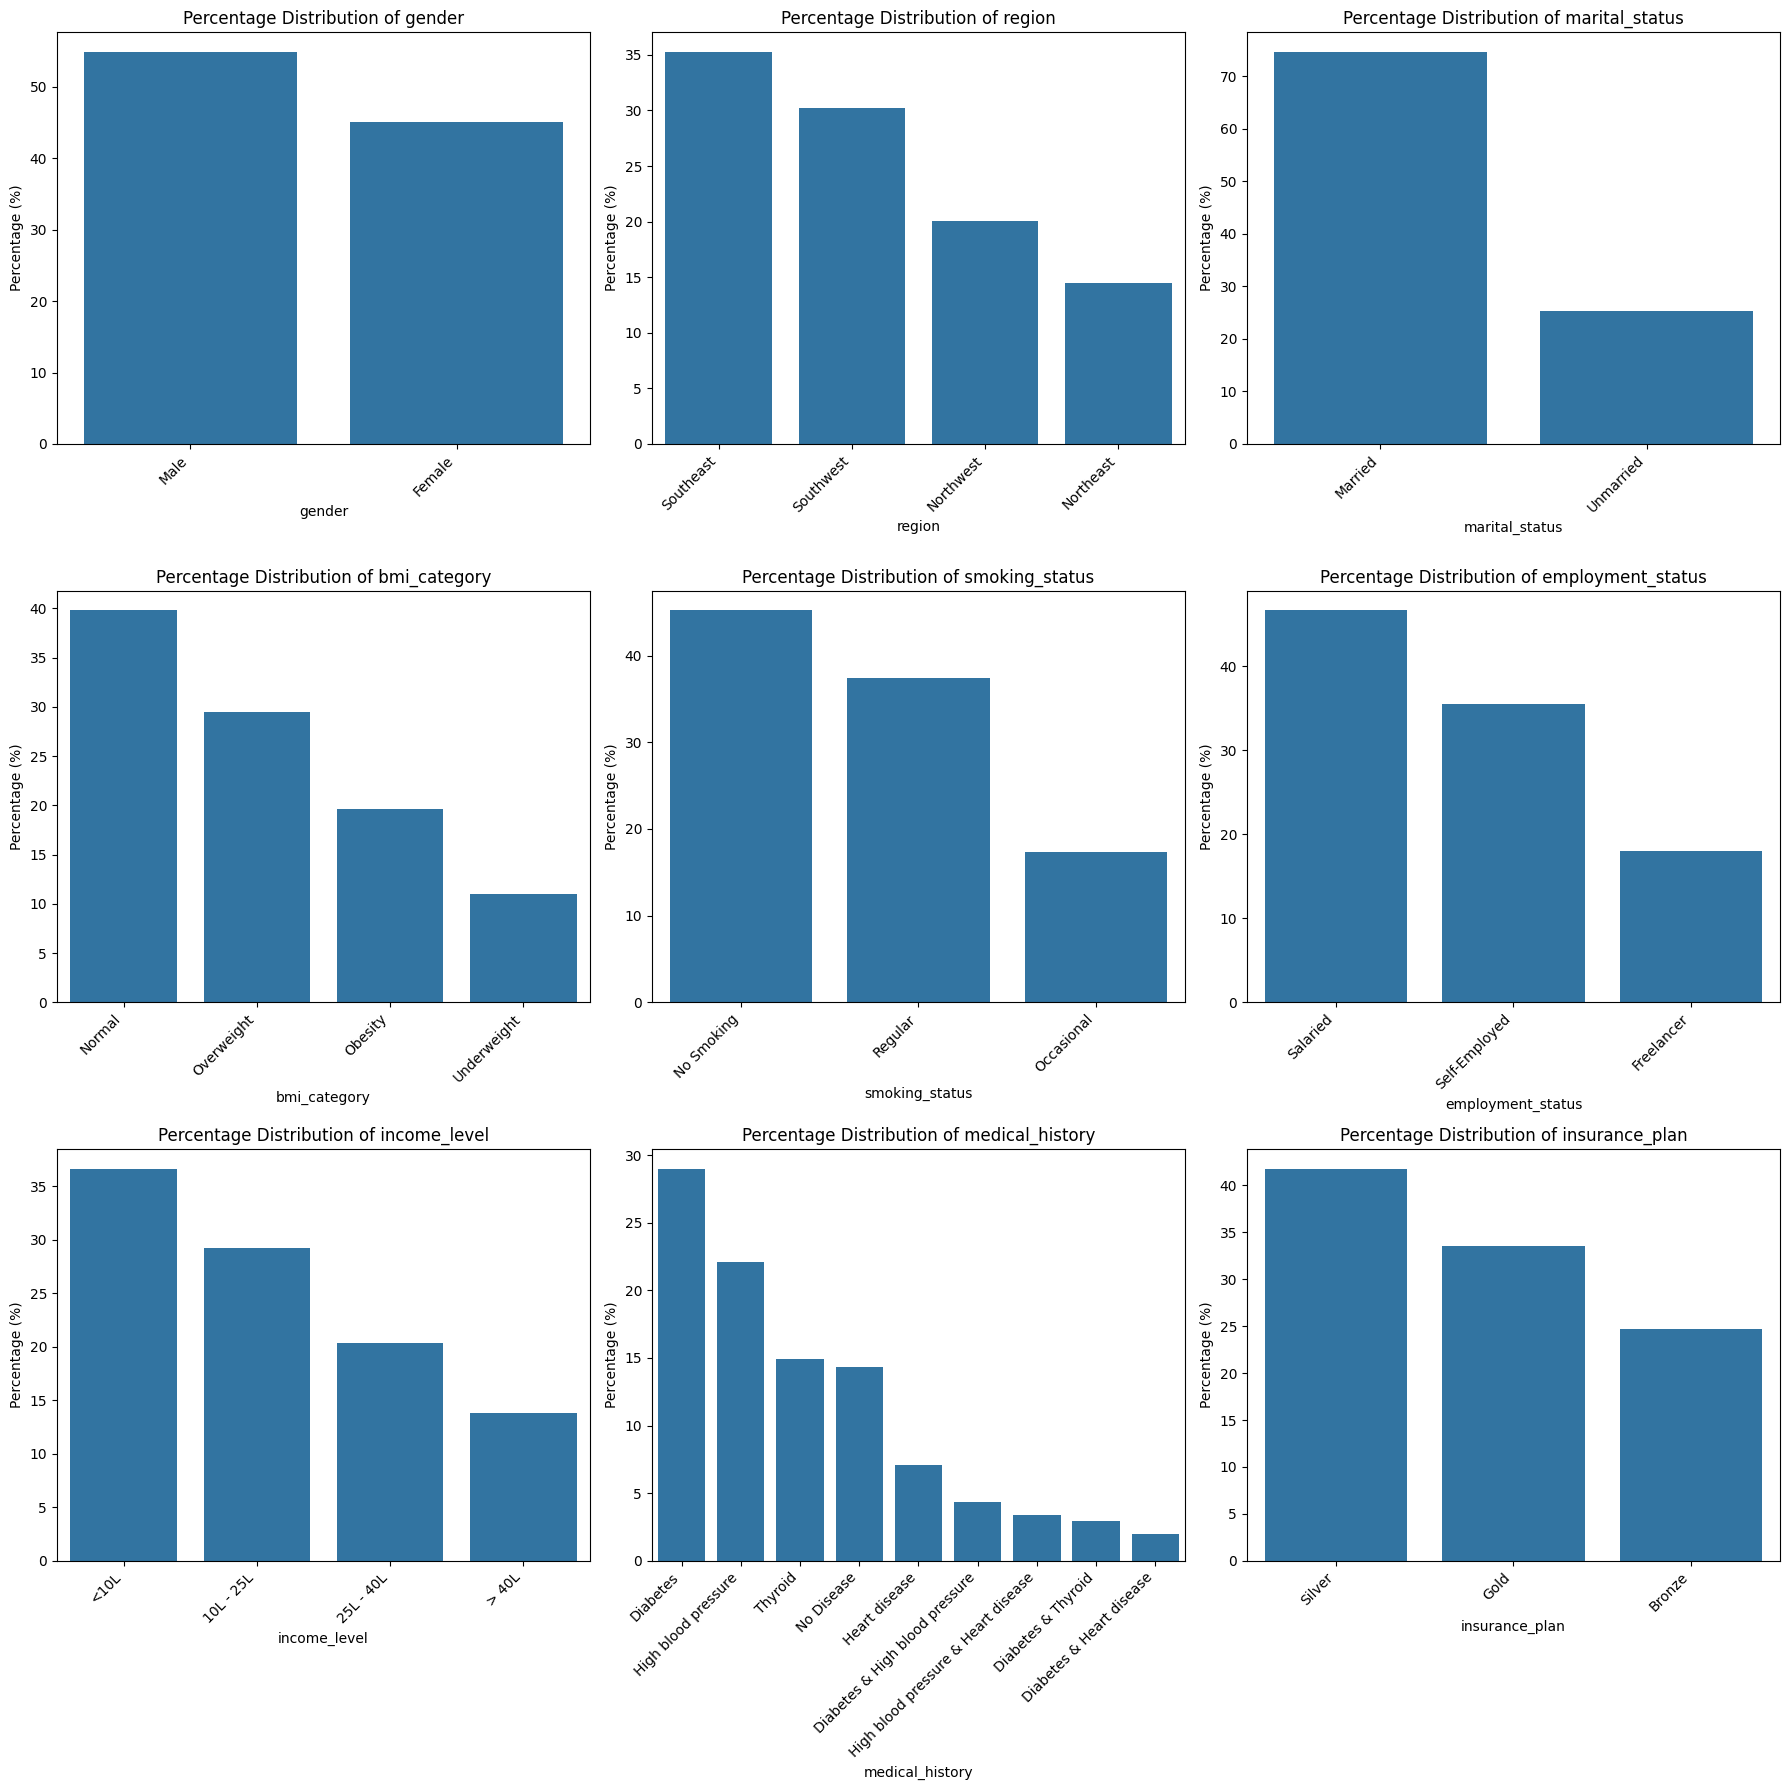

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18)) # You can adjust the size as necessary
axes = axes.flatten() #This will flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
  #Calculate the percentage distribution of each category
  category_counts = df2[column].value_counts(normalize=True) * 100

  #Plotting the distribution using barplot
  sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
  ax.set_title(f'Percentage Distribution of {column}')
  ax.set_xlabel(column) #Set xlabel to the column name for clarity
  ax.set_ylabel('Percentage (%)')

  # Rotate x labels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() # You can adjust layout
plt.show()


insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


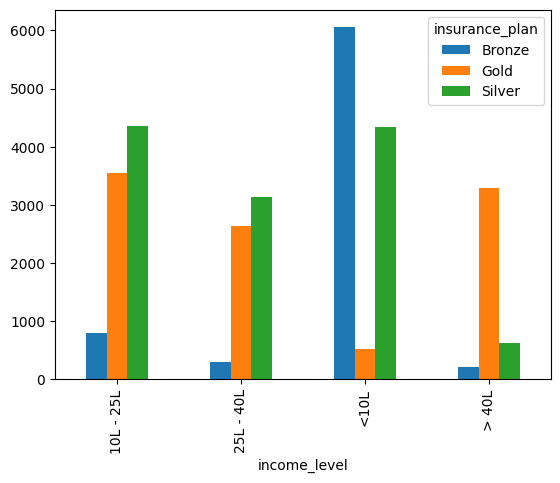

In [36]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar')
plt.show()

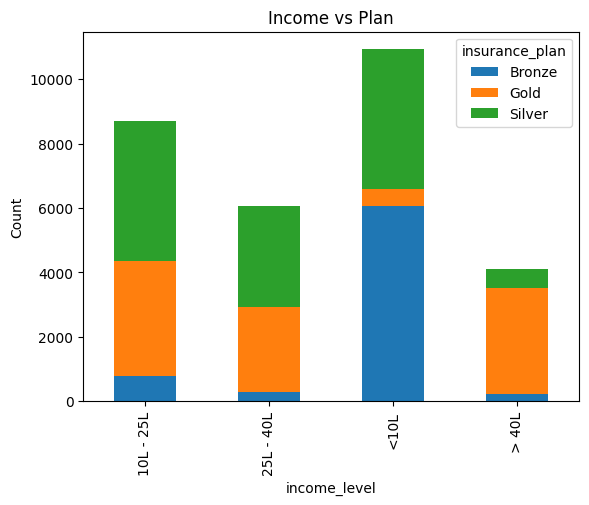

In [37]:
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

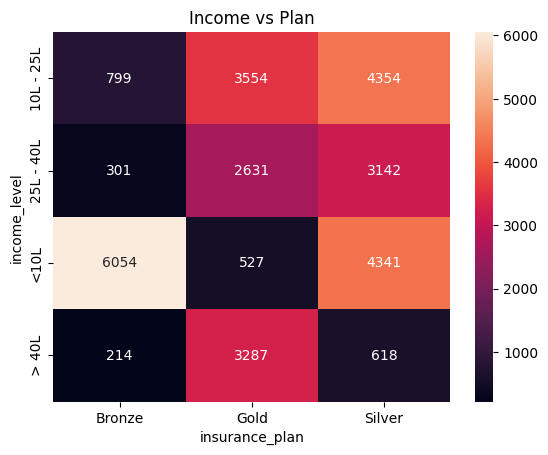

In [38]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.title('Income vs Plan')
plt.show()

## Feature Engineering

In [39]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [40]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [41]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [42]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None


In [43]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
  df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

/tmp/ipython-input-4122238453.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/tmp/ipython-input-4122238453.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [44]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [45]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571


In [46]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571


In [47]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [48]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29822 entries, 0 to 29903
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29822 non-null  int64  
 1   number_of_dependants             29822 non-null  int64  
 2   income_level                     29822 non-null  int64  
 3   income_lakhs                     29822 non-null  int64  
 4   medical_history                  29822 non-null  object 
 5   insurance_plan                   29822 non-null  int64  
 6   annual_premium_amount            29822 non-null  int64  
 7   disease1                         29822 non-null  object 
 8   disease2                         29822 non-null  object 
 9   total_risk_score                 29822 non-null  int64  
 10  normalized_risk_score            29822 non-null  float64
 11  gender_Male                      29822 non-null  int64  
 12  region_Northwest       

### Feature Selection

In [49]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


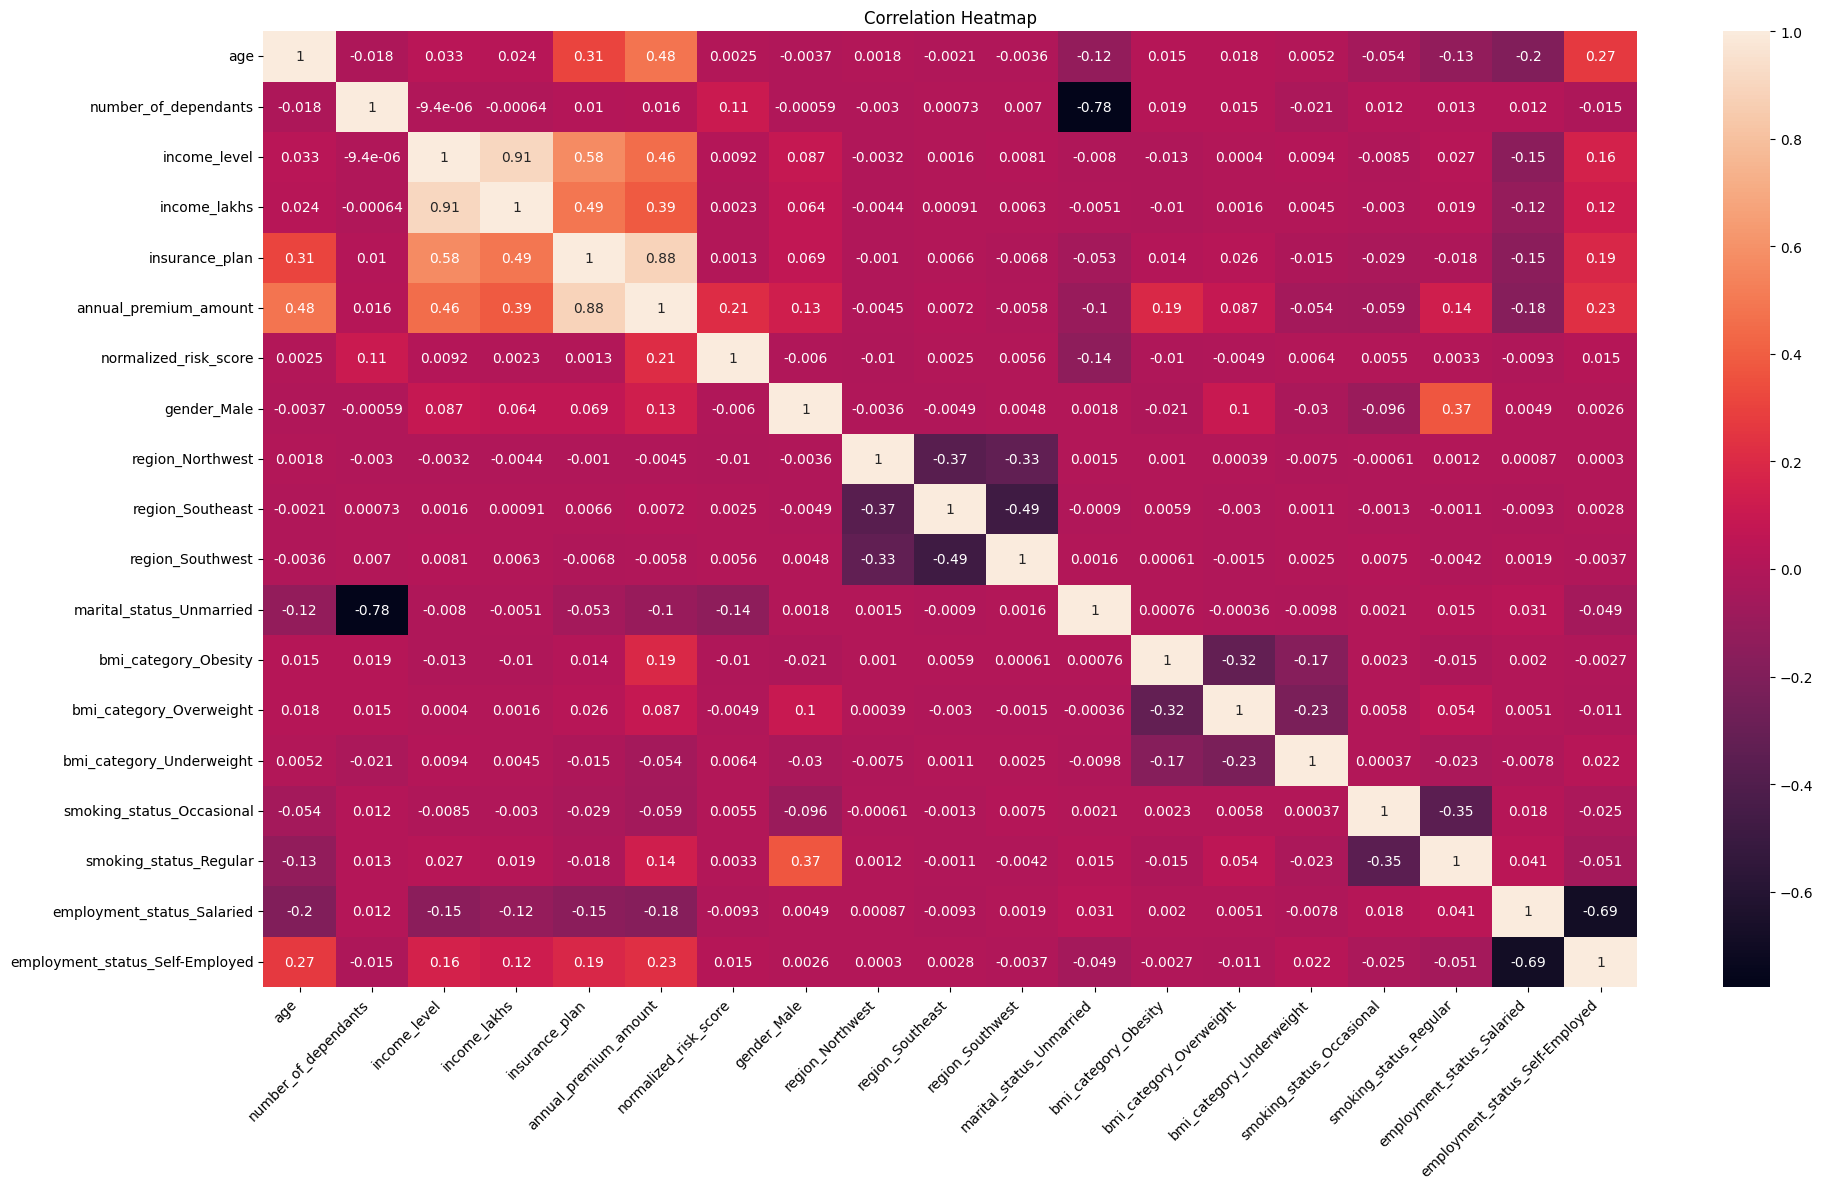

In [50]:
cm = df4.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [51]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [52]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Calculate the VIF

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
  vif_df = pd.DataFrame()
  vif_df['Column'] = data.columns
  vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif_df

In [54]:
df4.isnull().sum()

,0
age,0
number_of_dependants,0
income_level,0
income_lakhs,0
insurance_plan,0
annual_premium_amount,0
normalized_risk_score,0
gender_Male,0
region_Northwest,0
region_Southeast,0


In [55]:
calculate_vif(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [56]:
calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [57]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


# Model Training

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (20875, 17)
x test:  (8947, 17)
y train:  (20875,)
y test:  (8947,)


#### Linear Regression Model

In [59]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [60]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183844.360312456 RMSE:  1477.7835972538253


In [61]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1


In [62]:
model_lr.intercept_

np.float64(5935.981289344598)

In [63]:
model_lr.coef_

array([ 7016.2393283 , -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [64]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [65]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])
coef_df

,Coefficients
age,7016.239328
number_of_dependants,-1311.764702
income_lakhs,-708.193369
insurance_plan,14835.988208
normalized_risk_score,6053.624123
gender_Male,37.558269
region_Northwest,-55.250872
region_Southeast,-19.622543
region_Southwest,-22.289676
marital_status_Unmarried,-700.320200


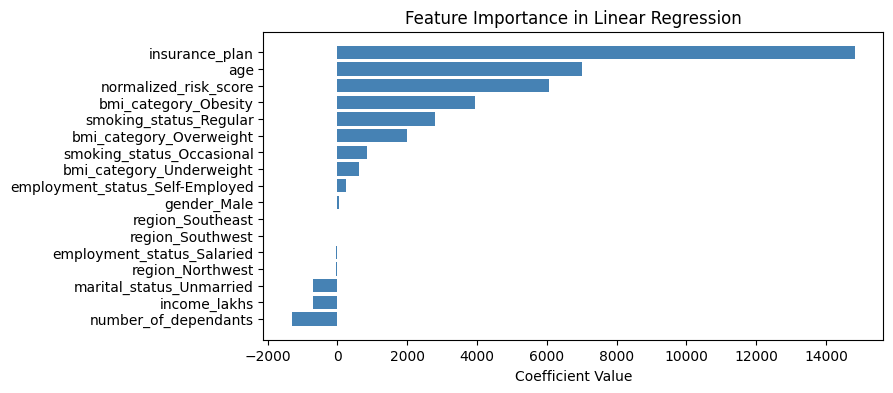

In [66]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### Ridge Regrssion Model

In [67]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9534162332209687, 0.9538456995663842)

In [68]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  2183803.933971564 RMSE:  1477.769919159124


#### XGBoost model

In [69]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9948463439941406

In [70]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9970577955245972)

In [71]:
y_pred = random_search.best_estimator_.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  139540.4375 RMSE:  373.5511176532604


In [72]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [73]:
best_model = random_search.best_estimator_

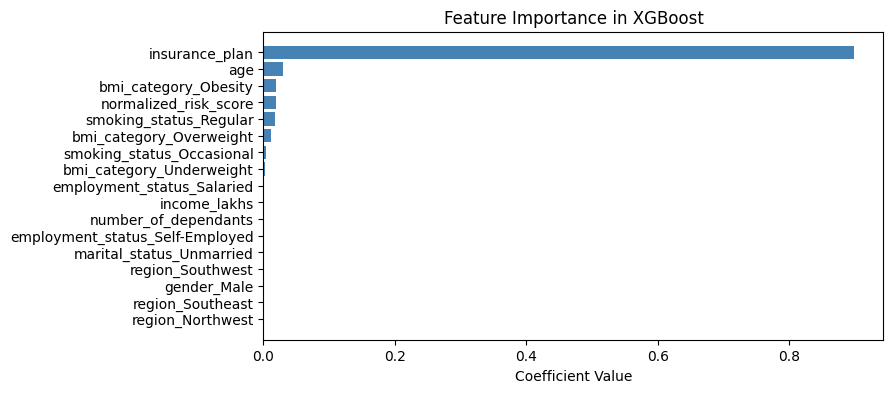

In [74]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

# Error Analysis

In [75]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Diff': residuals,
    'Diff_pct': residuals_pct
})

results_df.head()

,Actual,Predicted,Diff,Diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


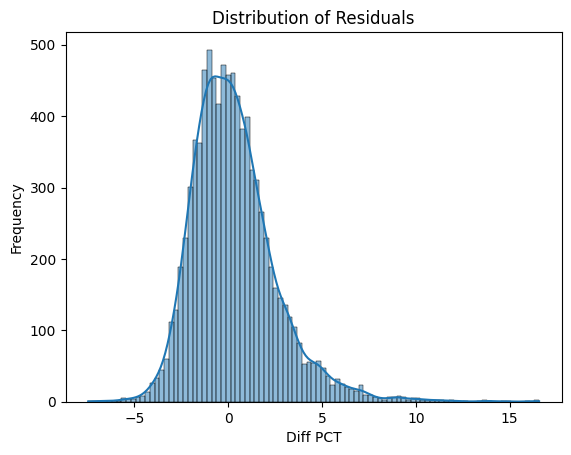

In [76]:
sns.histplot(results_df['Diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [77]:
X_test.shape, y_test.shape

((8947, 17), (8947,))

In [78]:
extreme_error_threshold = 10
extreme_results_df = results_df[results_df['Diff_pct'].abs() > extreme_error_threshold]
extreme_results_df.head()

,Actual,Predicted,Diff,Diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237


In [79]:
extreme_results_df.shape

(29, 4)

In [80]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

0.32413099362914943

According to this, We have 32% extreme errors which means for 32% customers will either overcharge or undercharge by 10% or more

In [81]:
extreme_results_df[abs(extreme_results_df.Diff_pct)>50].sort_values(by='Diff_pct', ascending=False)

,Actual,Predicted,Diff,Diff_pct


There will be about 548 customers whom we will overcharge or undercharge by more than 50%

In [82]:
X_test.index

Index([19713, 14750, 19932, 29643, 17076, 20314, 24893, 26722, 25844, 10731,
       ...
       10637,  1224, 17046, 19228,  9275,  3387,  7858,  9744,  4849,  8986],
      dtype='int64', length=8947)

In [83]:
extreme_results_df.index

Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [84]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0


In [85]:
extreme_errors_df.shape

(29, 17)

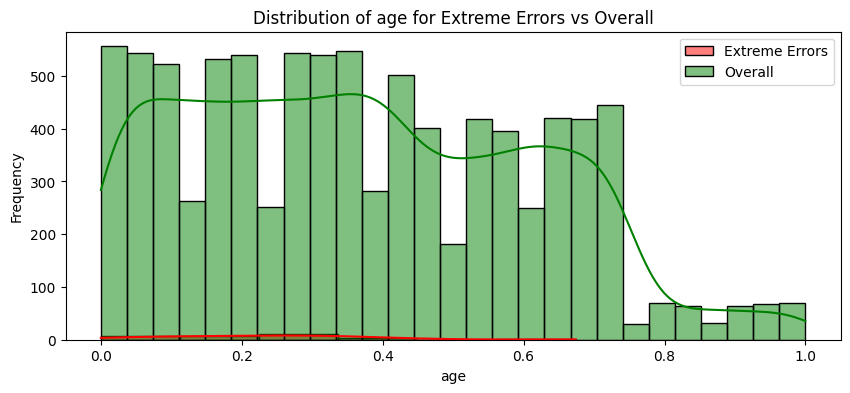

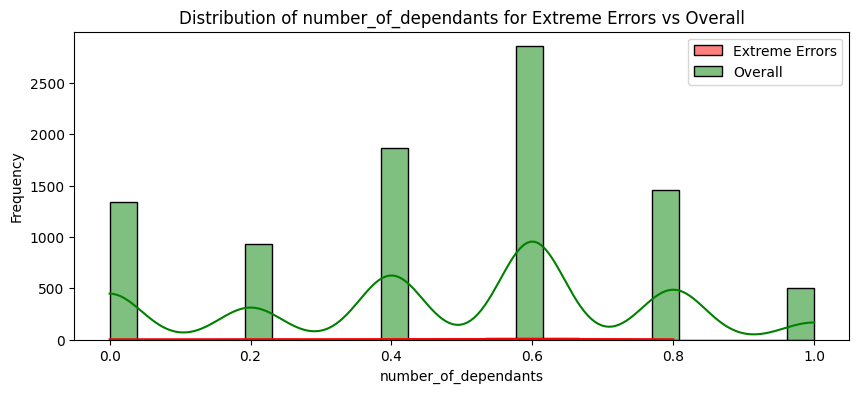

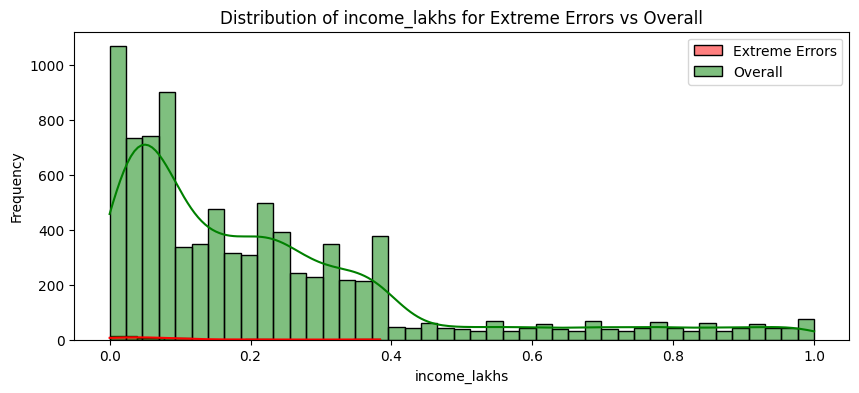

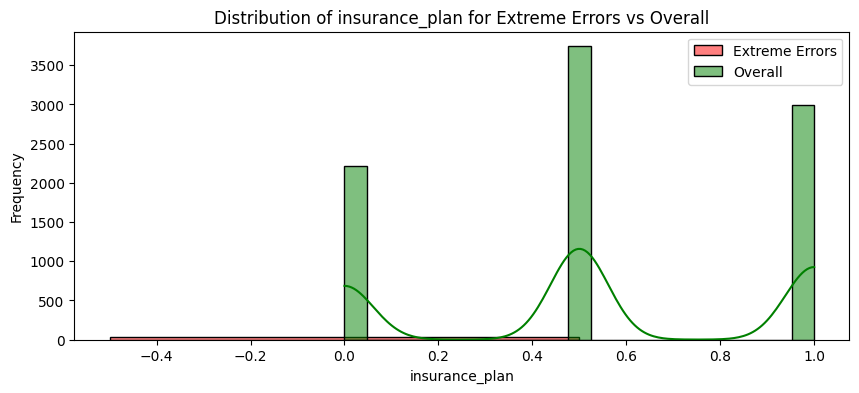

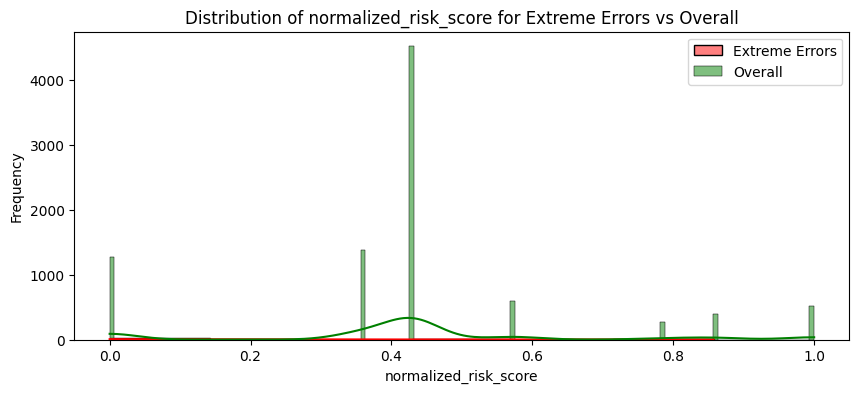

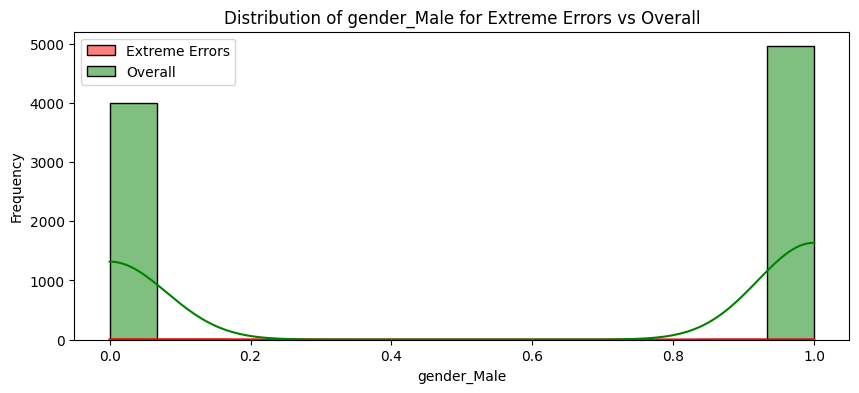

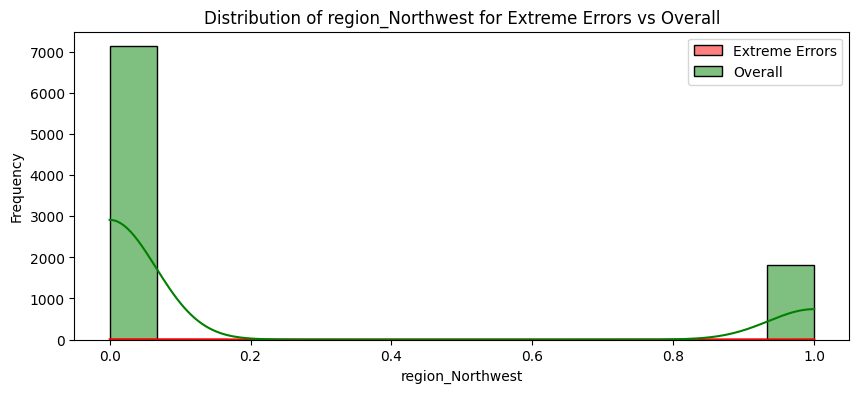

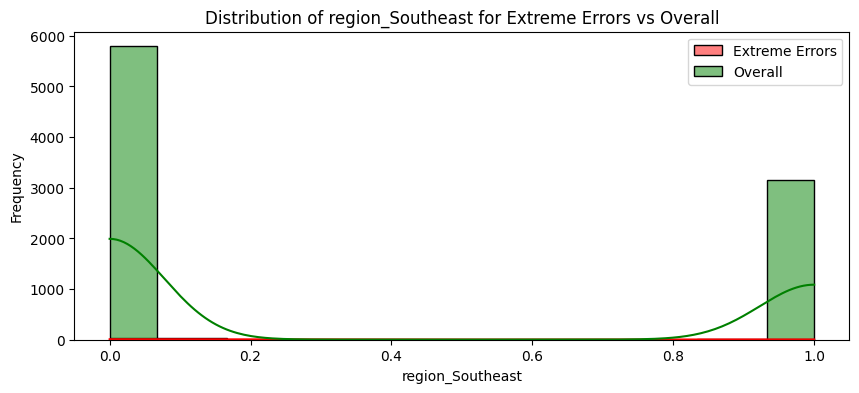

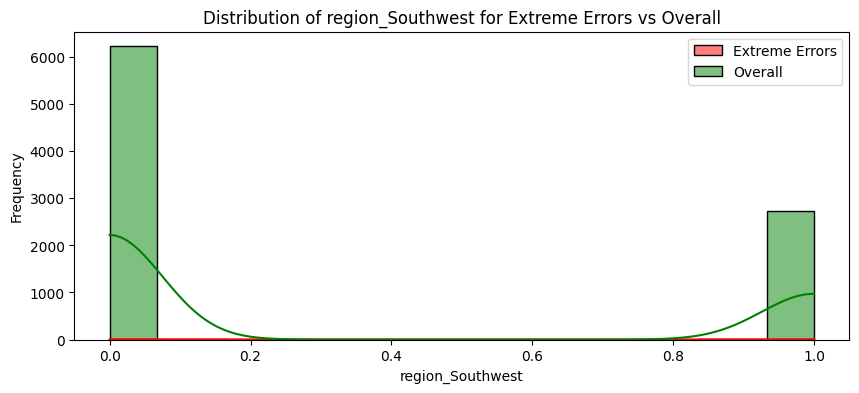

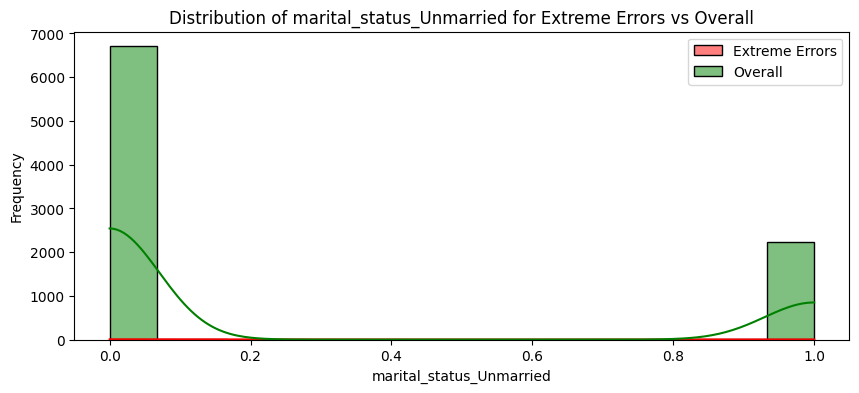

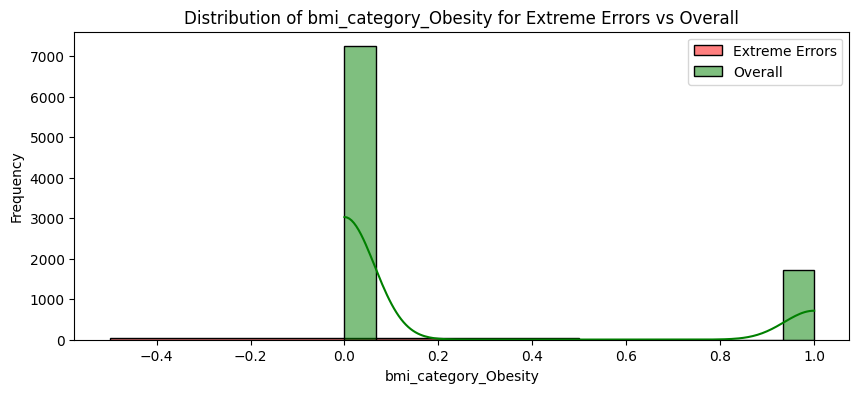

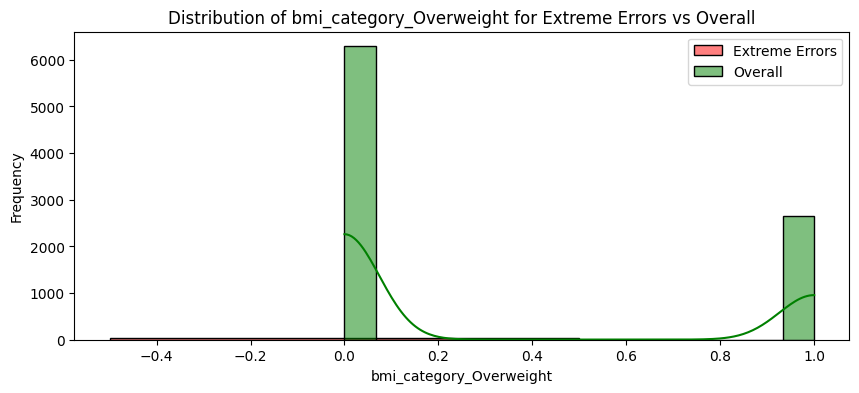

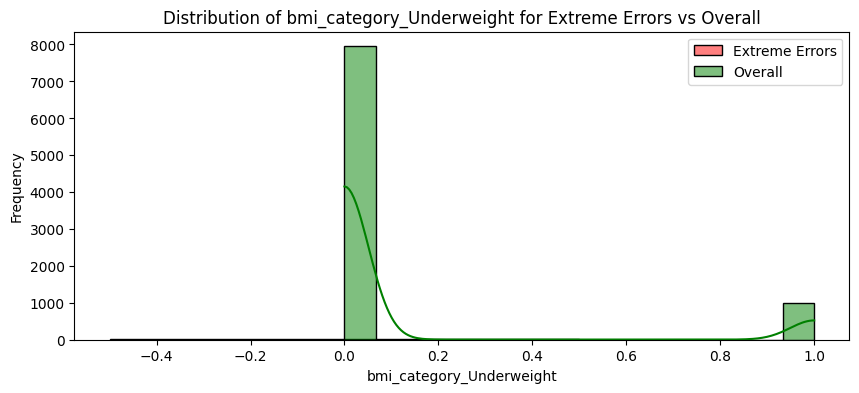

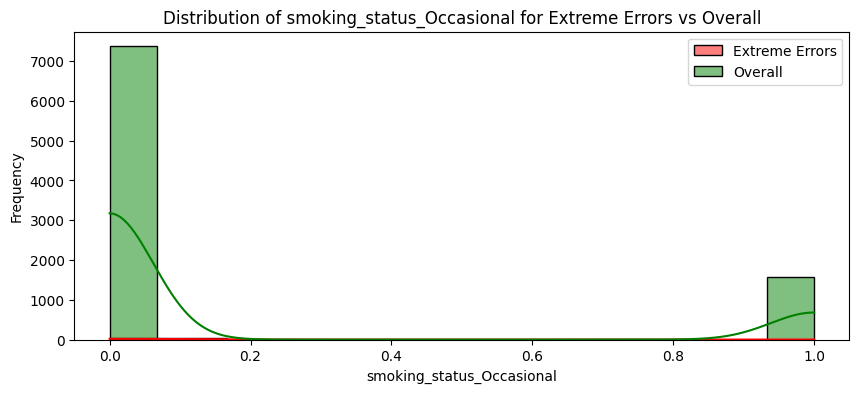

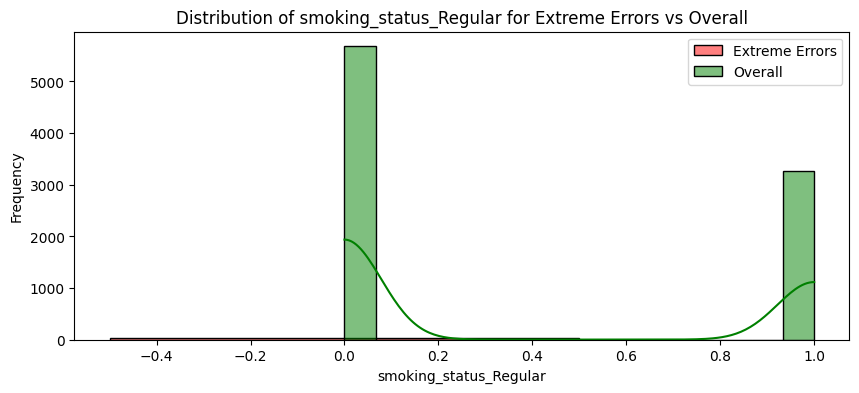

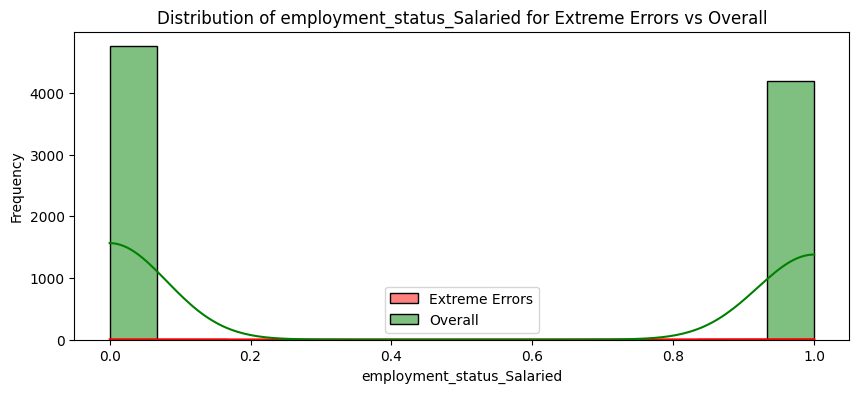

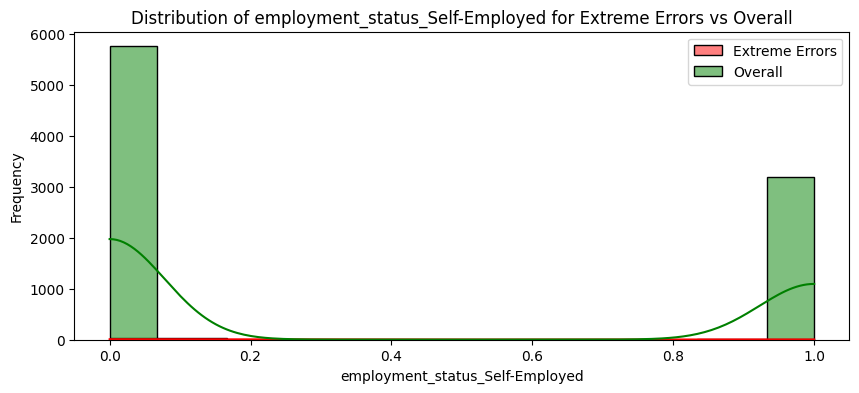

In [86]:
for feature in X_test.columns:
  plt.figure(figsize=(10, 4))
  sns.histplot(extreme_errors_df[feature], color='red',  label='Extreme Errors', kde=True)
  sns.histplot(X_test[feature], color='green', label='Overall', alpha=0.5, kde=True)
  plt.legend()
  plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

In here, we can clearly see errors occurred due to the age and the normalized risk score

To correct the normalized risk score, it is advisable to review the entire code again. Regarding age, we first need to determine the age group range and perform model segmentation.

#### Reverse Scalling

In [87]:
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0


In [88]:
extreme_errors_df['income_level']=-1

In [89]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0


In [90]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0


<Axes: xlabel='age', ylabel='Count'>

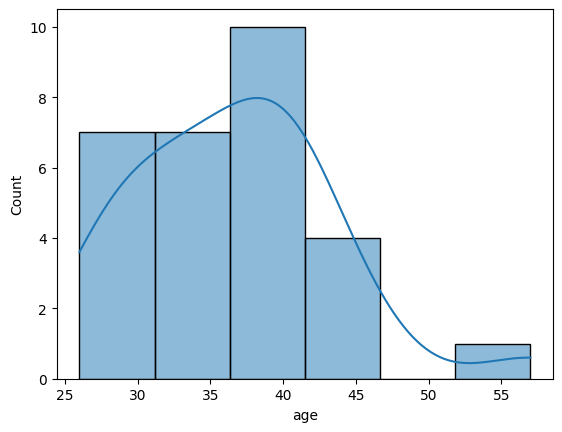

In [91]:
sns.histplot(df_reversed['age'], kde=True)

This indicates that most extreme errors are occurring in the younger age group (i.e., those under 25 years old). We should consider developing a separate model for this segment.